# Import Module

In [42]:
# Computational modules 
%matplotlib inline
import xarray as xr
import glob
import os
import numpy as np
import netCDF4
from netCDF4 import Dataset
import pandas as pd
import re
from array import array
from pylab import *
#import geopandas
from eofs.xarray import Eof
from eofs.multivariate.standard import MultivariateEof

# Plotting modules 
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import pandas.plotting
import matplotlib.ticker as ticker
import seaborn as sns
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.colors import BoundaryNorm

# Scikit-learn
from sklearn import linear_model
from sklearn.linear_model import LassoCV, LassoLarsCV, LassoLarsIC
from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score
from sklearn import preprocessing
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.neural_network import MLPRegressor
from scipy.optimize import minimize
from scipy.optimize import dual_annealing
from scipy import stats
from sklearn.decomposition import PCA

# Settings

### Variables

In [43]:
variables = ['psl']
variable = 'psl'
TITLE = 'Sea Level Pressure'
ylabel = '$E_{psl}$ ($Pa$)'

### Paths

In [44]:
path_PPE='/data/scratch/globc/peatier/CNRM-CM6-1_PPE/'
#'/data/scratch/globc/peatier/CNRM-CM6-1_PPE/ENSEMBLE2/CNRM-CM6-1_amip_PPE_regrid/'
group_name='CNRM-CM6-1_amip_LHS500_PPE/' #'CNRM-CM6-1_amip_PPE_regrid/'
path_files='/data/home/globc/peatier/CNRMppe_error_decomposition/files/'

### List of members

In [45]:
nb_p_list = ['p311', 'p312', 'p314', 'p316',
                    'p317', 'p319', 'p320', 'p321', 'p322', 'p324', 'p325', 'p326', 
                    'p329', 'p330', 'p331', 'p332', 'p335', 'p336', 'p337' ,'p338', 
                    'p340', 'p341', 'p343', 'p344', 'p346', 'p347', 'p348', 'p349', 
                    'p350', 'p353', 'p355', 'p357', 'p359', 'p360', 
                    'p361', 'p363', 'p365', 'p367', 'p368', 'p369', 
                    'p372', 'p373', 'p374', 'p375', 'p376', 'p378', 'p381', 'p382', 
                    'p384', 'p386', 'p388', 'p389', 'p391', 'p392', 'p393', 
                    'p394', 'p395', 'p396', 'p398', 'p399', 'p400', 'p404', 
                    'p406', 'p407', 'p409', 'p410', 'p411', 'p412',
                    'p414','p416',
                    'p413','p419','p424','p426','p428','p421','p423',
                    'p425','p427','p429','p430','p436','p438','p431','p433',
                    'p442','p446','p443','p445','p447',
                    'p452','p454','p456','p458','p457','p459',
                    'p460','p465','p467','p469',
                    'p470','p471']

len(nb_p_list)

102

# Functions

In [46]:
def MSE(mod, obs, W_rmse_2D) :
    diff_tmp = (mod - obs)**2 * W_rmse_2D
    diff = (diff_tmp.sum(['lat', 'lon']))
    return diff

In [47]:
def reconstruct_X(eofs_combined, pc, nb_dims) :
    X_rec_tmp = np.dot(eofs_combined.transpose(),pc)
    if nb_dims == 3 :
        X_rec = xr.DataArray(X_rec_tmp, 
                        dims=["lon", "lat", "time"]).transpose('time', 'lat', 'lon')
    if nb_dims == 2 :
        X_rec = xr.DataArray(X_rec_tmp, 
                        dims=["lon", "lat"]).transpose('lat', 'lon')
    
    X_rec['lat'] = eofs_combined['lat']
    X_rec['lon'] = eofs_combined['lon']
    return X_rec

In [48]:
def MSE_rec(rec_anom_mod_w, rec_anom_obs_w, Mean, W_rmse_2D) :
    mod = rec_anom_mod_w/W_eof_2D + Mean
    obs = rec_anom_obs_w/W_eof_2D + Mean
    diff = MSE(mod, obs, W_rmse_2D)
    return diff

In [49]:
def get_3D_psl_xarr(path, filename, variables):

    # First step : download the data into dataframe
    file = xr.open_mfdataset(path+filename,combine='by_coords')
    
    # Second step : compute the annual average 
    df = file[variables].mean('time', keep_attrs=True)
    psl = df['psl']
    
    return psl

In [50]:
def load_monthly_clim(path, filename, variables) :
    
    file = xr.open_mfdataset(path+filename,combine='by_coords')
    df=file[variables].to_dataframe()
    
    # Compute Climatological Annual Cycle :
    df1=df.reset_index(level=['time', 'lat', 'lon'])
    df1['year']=pd.DatetimeIndex(df1['time']).year
    df1['month']=pd.DatetimeIndex(df1['time']).month
    
    #list_ind = []
    #cpt=0
    #for i in df1['year'] : 
    #    if i>1981 :
    #        list_ind.append(cpt)
    #        cpt+=1
    #    else : 
    #        cpt+=1
            
    #df2 = df1.drop(list_ind)
    df_mean=df1.groupby(['month', 'lat', 'lon']).mean()
    df_mean=df_mean.drop(columns='year')
    
    return df_mean

# Get data : obs, PPE, p1

In [51]:
path_observation = '/data/scratch/globc/peatier/obs_data/NCEP/regrid_CNRM/'  #path_PPE
filename_obs = 'psl_1m_1979-1981_NCEP_regrid.nc' #'psl_1m_1979-1981_NCEP.nc'

In [76]:
variables = [variable]
df_obs = load_monthly_clim(path_observation, filename_obs, variables)
df_obs

psl
month lat        lon                     
1     -88.927735 0.00000     99413.804688
                 1.40625     99413.843750
                 2.81250     99413.851562
                 4.21875     99413.757812
                 5.62500     99413.578125
...                                   ...
12     88.927735 352.96875  101209.882812
                 354.37500  101209.617188
                 355.78125  101209.382812
                 357.18750  101209.171875
                 358.59375  101208.929688

[393216 rows x 1 columns]

In [77]:
X_obs = df_obs.groupby(['lat','lon']).mean().to_xarray()*0.01
X_obs

<xarray.Dataset>
Dimensions:  (lat: 128, lon: 256)
Coordinates:
  * lat      (lat) float64 -88.93 -87.54 -86.14 -84.74 ... 86.14 87.54 88.93
  * lon      (lon) float64 0.0 1.406 2.812 4.219 ... 354.4 355.8 357.2 358.6
Data variables:
    psl      (lat, lon) float32 1024.1908 1024.2943 ... 1015.0329 1015.0366

In [78]:
# Default simulation
path_official=path_PPE+'ENSEMBLE1/CNRM-CM6-1_amip_PPE/CNRM-CM6-1_amip_r1i1p1f2/'
#path_PPE+'reference/CNRM-CM6-1_amip_r1i1p1f2/'
filename = variable+'*_CNRM-CM6-1_amip_*.nc'
p1_amip = get_3D_psl_xarr(path_official, filename, variables)*0.01

In [79]:
# PPE amip simulations 
filename=variable+'*_amip_*.nc'

N=len(nb_p_list)
amip={}
i = 0
while i<N:
    nb_p = nb_p_list[i]
    #print(nb_p)
    path=path_PPE+'ENSEMBLE2/CNRM-CM6-1_amip_LHS500_PPE/CNRM-CM6-1_amip_r1i1'+str(nb_p)+'f2/'
    #path_PPE+'CNRM-CM6-1_amip_r1i1'+str(nb_p)+'f2/'
    amip[str(nb_p)] = get_3D_psl_xarr(path, filename, variables)*0.01
    i=i+1

In [80]:
amip['p1'] = p1_amip

# Calcule full MSE (ej)

In [81]:
n=len(nb_p_list)
amip_list=[0]*(n+1)

amip_list[0] = amip['p1']

i = 0
while i<n:
    nb_p = nb_p_list[i]
    #print(nb_p)
    tmp = amip[str(nb_p)]
    amip_list[i+1] = tmp
    i+=1

In [82]:
matrix = xr.combine_nested(amip_list, concat_dim=['time'])

In [83]:
## --Get weights : 
lats = matrix['lat'].values

wgts = np.cos(np.deg2rad(lats))
W_eof_2D = sqrt(abs(wgts))[:,np.newaxis] ## --Wqts before EOF analysis - 2D (lat x lon)
W_eof_3D = sqrt(abs(wgts))[np.newaxis,:,np.newaxis] ## --Wqts before EOF analysis - 3D (time x lat x lon)

S = wgts.sum()*256  #*144 ## --Sum of wgts over the whole grid
wgts_sum = wgts/S
W_rmse_2D = wgts_sum[:,np.newaxis] ## -- Wgts before RMSE, divided by sum of wgts - 2D (lat x lon)

In [84]:
variable_obs='psl'

In [85]:
# Reference p1
mod = amip['p1']
obs = X_obs[variable]
diff_p1 = MSE(mod, obs, W_rmse_2D)

In [86]:
ej_list = []
#ej['p1'] = diff_p1

for p in nb_p_list :
    mod = amip[p]
    obs = X_obs[variable_obs]
    diff = MSE(mod, obs, W_rmse_2D)
    ej_list.append(diff)


### Save

In [87]:
np.save(path_files+'npy/CNRMppe_decomposition_ej_'+str(variable)+'.npy', ej_list)

# EOF + truncated RMSE (rj)

## EOF

In [88]:
# Compute anomalies by removing the time-mean.
mean = matrix.mean(axis=0)
anom = matrix - mean
anom

<xarray.DataArray 'psl' (time: 103, lat: 128, lon: 256)>
dask.array<sub, shape=(103, 128, 256), dtype=float32, chunksize=(1, 128, 256), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -88.93 -87.54 -86.14 -84.74 ... 86.14 87.54 88.93
  * lon      (lon) float64 0.0 1.406 2.812 4.219 ... 354.4 355.8 357.2 358.6
Dimensions without coordinates: time

In [89]:
anom_w = (anom*W_eof_3D)#.to_array()
anom_w

<xarray.DataArray 'psl' (time: 103, lat: 128, lon: 256)>
dask.array<mul, shape=(103, 128, 256), dtype=float64, chunksize=(1, 128, 256), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -88.93 -87.54 -86.14 -84.74 ... 86.14 87.54 88.93
  * lon      (lon) float64 0.0 1.406 2.812 4.219 ... 354.4 355.8 357.2 358.6
Dimensions without coordinates: time

In [90]:
# Create an EOF solver to do the EOF analysis. 
solver = Eof(anom_w, center=False, weights=None)

In [91]:
eof = solver.eofsAsCovariance(neofs=102, pcscaling=1)
pc = solver.pcs(npcs=102, pcscaling=1)

In [92]:
varFrac = solver.varianceFraction(neigs=102)
#varFrac

### Save

In [93]:
for i in range(0,len(eof),1) : 
    j = i+1
    # EOFmap
    EOF_df = eof[i].to_dataframe().drop(labels = 'mode', axis=1)
    EOF_df.to_pickle(path_files+"npy/CNRMppe_decomposition_EOFmap"+str(j)+"_"+str(variable)+".npy")

In [94]:
## --Save the pc_p1 and pc_PPE in a .nc files
path_file = path_files+'nc/'
filename = 'CNRMppe_decomposition_p1_EOFpc_'+str(variable)+'.nc'
pc[0, :].to_netcdf(path=path_file+filename)
filename = 'CNRMppe_decomposition_EOFpc_'+str(variable)+'.nc'
pc[1:, :].to_netcdf(path=path_file+filename)

In [95]:
mean_df = mean.to_dataframe(name=str(variable)+'mean')#.drop(labels = 'height', axis=1)
mean_df.to_pickle(path_files+'npy/CNRMppe_decomposition_mean_'+str(variable)+'.npy')

## Get the observations

In [96]:
Mean =  pd.read_pickle(path_files+'npy/CNRMppe_decomposition_mean_'+str(variable)+'.npy').to_xarray().to_array()
Mean = Mean[0,:,:].rename({'variable':'mode'})
X_obs_anom = X_obs[variable_obs] - Mean
X_obs_anom

<xarray.DataArray (lat: 128, lon: 256)>
array([[ 4.020569 ,  4.1240845,  4.226013 , ...,  3.677124 ,  3.7960205,
         3.9091187],
       [ 5.607361 ,  5.845215 ,  6.0790405, ...,  4.819092 ,  5.092041 ,
         5.3516846],
       [ 5.6016846,  5.7980957,  5.9853516, ...,  5.2158203,  5.0930176,
         5.354126 ],
       ...,
       [-2.481079 , -2.4942627, -2.5076904, ..., -2.4955444, -2.4577026,
        -2.4691772],
       [-2.1868896, -2.1795044, -2.1722412, ..., -2.2124023, -2.2039185,
        -2.1953735],
       [-2.8145142, -2.8112793, -2.8081055, ..., -2.8256836, -2.8218994,
        -2.8181763]], dtype=float32)
Coordinates:
  * lat      (lat) float64 -88.93 -87.54 -86.14 -84.74 ... 86.14 87.54 88.93
  * lon      (lon) float64 0.0 1.406 2.812 4.219 ... 354.4 355.8 357.2 358.6
    mode     <U7 'pslmean'

## Parametric component of the error for different q

In [97]:
def Error_PPE_param_component(path_files, variable, Mean, W_eof_2D, W_rmse_2D, q) :
    ## --Get the eofs
    eofs=[]
    for j in range(1,q+1,1) :
        eof_tmp = pd.read_pickle(path_files+"npy/CNRMppe_decomposition_EOFmap"+str(j)+"_"+str(variable)+".npy").to_xarray().to_array()
        eof_tmp = eof_tmp[0,:,:].rename({'variable':'mode'})
        eofs.append(eof_tmp)      
    ## --Combine the modes for reconstruction
    eofs_combined = xr.combine_nested(eofs, concat_dim='eofs')
    
    ## --Get the pc_PPE
    path_file = path_files+'nc/'
    filename = 'CNRMppe_decomposition_EOFpc_'+str(variable)+'.nc'
    pc_PPE = xr.open_dataset(path_file+filename)
    pc_PPE_trunc = pc_PPE['pcs'][:,0:q]

    ## -- Project the observations :
    X_obs_W = X_obs_anom*W_eof_2D
    U_obs = solver.projectField(X_obs_W, neofs=q, weighted=False, eofscaling=1)

    ## -- reconstruct X_obs_rec : 
    pc=U_obs
    nb_dims = 2
    X_obs_rec = reconstruct_X(eofs_combined, pc, nb_dims)
    ## -- reconstruct X_mod_rec : 
    pc=pc_PPE_trunc
    nb_dims = 3
    X_mod_rec = reconstruct_X(eofs_combined, pc.transpose(), nb_dims)

    pj_list = MSE_rec(X_mod_rec, X_obs_rec, Mean, W_rmse_2D)

    return pj_list

In [98]:
df_fig = pd.DataFrame(ej_list, columns=['ej'])

## -- 5 modes :
q = 5
pj_list = Error_PPE_param_component(path_files, variable, Mean, W_eof_2D, W_rmse_2D, q)
df_fig['pj ' +str(q)+' modes'] = pj_list
df_fig['uj ' +str(q)+' modes'] = abs(df_fig['ej'] - df_fig['pj ' +str(q)+' modes'])

## -- 20 modes :
q = 20
pj_list = Error_PPE_param_component(path_files, variable, Mean, W_eof_2D, W_rmse_2D, q)
df_fig['pj ' +str(q)+' modes'] = pj_list
df_fig['uj ' +str(q)+' modes'] = abs(df_fig['ej'] - df_fig['pj ' +str(q)+' modes'])

## -- 50 modes :
q = 50
pj_list = Error_PPE_param_component(path_files, variable, Mean, W_eof_2D, W_rmse_2D, q)
df_fig['pj ' +str(q)+' modes'] = pj_list
df_fig['uj ' +str(q)+' modes'] = abs(df_fig['ej'] - df_fig['pj ' +str(q)+' modes'])

## -- 102 modes :
q = 102
pj_list = Error_PPE_param_component(path_files, variable, Mean, W_eof_2D, W_rmse_2D, q)
df_fig['pj ' +str(q)+' modes'] = pj_list
df_fig['uj ' +str(q)+' modes'] = abs(df_fig['ej'] - df_fig['pj ' +str(q)+' modes'])

#df_fig

In [99]:
df_fig_sort = df_fig.sort_values(by='ej')
df_fig_sort['members'] = range(1, len(ej_list)+1,1)
df_fig_sort

,ej,pj 5 modes,uj 5 modes,pj 20 modes,uj 20 modes,pj 50 modes,uj 50 modes,pj 102 modes,uj 102 modes,members
87,2.722579,0.436610,2.285969,0.806565,1.916014,1.432831,1.289748,1.810512,0.912067,1
39,2.878916,0.486384,2.392531,0.821555,2.057360,1.586640,1.292276,1.966848,0.912067,2
59,2.953164,0.332918,2.620247,0.946487,2.006678,1.668623,1.284541,2.041097,0.912067,3
60,2.982733,0.641333,2.341400,1.035790,1.946943,1.734297,1.248437,2.070666,0.912067,4
17,3.015877,0.275550,2.740327,0.994916,2.020961,1.757471,1.258407,2.103810,0.912067,5
...,...,...,...,...,...,...,...,...,...,...
36,14.283990,11.913981,2.370009,12.316508,1.967482,13.025964,1.258026,13.371923,0.912067,98
48,16.083698,13.172106,2.911591,13.879360,2.204338,14.759680,1.324017,15.171630,0.912067,99
11,19.403896,17.165451,2.238445,17.488369,1.915527,18.167849,1.236047,18.491829,0.912067,100
62,19.838268,17.480800,2.357468,17.667072,2.171196,18.546308,1.291960,18.926201,0.912067,101


## Error components ratio

In [100]:
q_list = [5,20,50,102]
ratio_p = {}
ratio_u = {}
for q in q_list :
    ratio_p[str(q)+' modes'] = (df_fig['pj ' +str(q)+' modes'].mean()/df_fig['ej'].mean())*100
    ratio_u[str(q)+' modes'] = (df_fig['uj ' +str(q)+' modes'].mean()/df_fig['ej'].mean())*100

In [101]:
ratio_p

{'5 modes': 62.46518161535456,
 '20 modes': 70.43238423622674,
 '50 modes': 82.14919566013093,
 '102 modes': 87.15793641315604}

In [102]:
ratio_u

{'5 modes': 37.534818384645405,
 '20 modes': 29.567615763773237,
 '50 modes': 17.85080433986905,
 '102 modes': 12.842063586843933}

# Figure - error decomposition

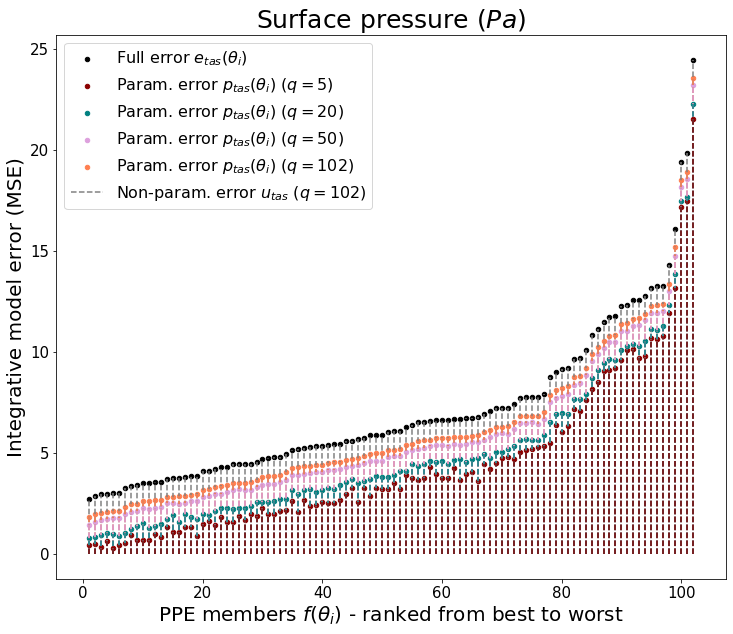

In [103]:
fig, ax = plt.subplots(figsize=(12,10))

df_fig_sort.plot(kind='scatter', x='members', y='ej', 
                           color='black', alpha=1, marker='o', ax = ax)


df_fig_sort.plot(kind='scatter', x='members', y='pj 5 modes', 
                           color='darkred', alpha=1, marker='o', ax = ax)  

df_fig_sort.plot(kind='scatter', x='members', y='pj 20 modes', 
                           color='teal', alpha=1, marker='o', ax = ax) 

df_fig_sort.plot(kind='scatter', x='members', y='pj 50 modes', 
                           color='plum', alpha=1, marker='o', ax = ax) 

df_fig_sort.plot(kind='scatter', x='members', y='pj 102 modes', 
                           color='coral', alpha=1, marker='o', ax = ax) 
    
cpt=1
for i in df_fig_sort['ej'] : 
    plt.vlines(cpt,ymin = 0,ymax = i, colors='gray',
           linestyles='dashed')
    cpt+=1

 
cpt=1
for i in df_fig_sort['pj 102 modes'] : 
    plt.vlines(cpt,ymin = 0,ymax = i, colors='coral', label='_nolegend_',
           linestyles='dashed')
    cpt+=1

cpt=1
for i in df_fig_sort['pj 50 modes'] : 
    plt.vlines(cpt,ymin = 0,ymax = i, colors='plum', label='_nolegend_',
           linestyles='dashed')
    cpt+=1
    
cpt=1
for i in df_fig_sort['pj 20 modes'] : 
    plt.vlines(cpt,ymin = 0,ymax = i, colors='teal', label='_nolegend_',
           linestyles='dashed')
    cpt+=1
    
cpt=1
for i in df_fig_sort['pj 5 modes'] : 
    plt.vlines(cpt,ymin = 0,ymax = i, colors='darkred', label='_nolegend_',
           linestyles='dashed')
    cpt+=1

legend=['Full error $e_{tas}(\\theta_i)$', 
        'Param. error $p_{tas}(\\theta_i)$ ($q=5$)', 
        'Param. error $p_{tas}(\\theta_i)$ ($q=20$)',
        'Param. error $p_{tas}(\\theta_i)$ ($q=50$)',
        'Param. error $p_{tas}(\\theta_i)$ ($q=102$)',
        'Non-param. error $u_{tas}$ ($q=102$)']
ax.tick_params(axis='both', which='major', labelsize=15)
plt.legend(legend, fontsize=18, loc='upper left') #, bbox_to_anchor=(1.5, 1.02))
plt.title('Precipitation ($mm/day$)', fontsize = 25)
plt.xlabel('Models - ranked from best to worst',fontsize=20)
plt.ylabel('Integrative model error (RMSE)', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.legend(legend, fontsize=16, loc='upper left') #, bbox_to_anchor=(1.5, 1.02))
plt.title('Surface pressure ($Pa$)', fontsize = 25)
plt.xlabel('PPE members $f(\\theta_i)$ - ranked from best to worst',fontsize=20)
plt.ylabel('Integrative model error (MSE)', fontsize=20)

# Enregistrer la figure ...........

plt.savefig("/data/home/globc/peatier/figures/PPE_ej_decompo_example_"+variable+".png", 
        orientation='portrait', bbox_inches='tight', pad_inches=0.1)

# Display the figure 
plt.show()

# Figure - correlation

In [104]:
def correlation(df_fig, q) :
    res = stats.linregress(df_fig['pj '+str(q)+' modes'], df_fig['ej'])
    x = np.arange(0.2,5.8,0.02)
    line = res.intercept + res.slope*x
    
    r = res.rvalue
    r_round = round(r,3)
    
    return [line, r_round]

In [105]:
corr = {}
## -- 5 modes :
q = 5
corr[str(q)+' modes'] = correlation(df_fig, q)

## -- 20 modes :
q = 20
corr[str(q)+' modes'] = correlation(df_fig, q)

## -- 50 modes :
q = 50
corr[str(q)+' modes'] = correlation(df_fig, q)

## -- 102 modes :
q = 102
corr[str(q)+' modes'] = correlation(df_fig, q)

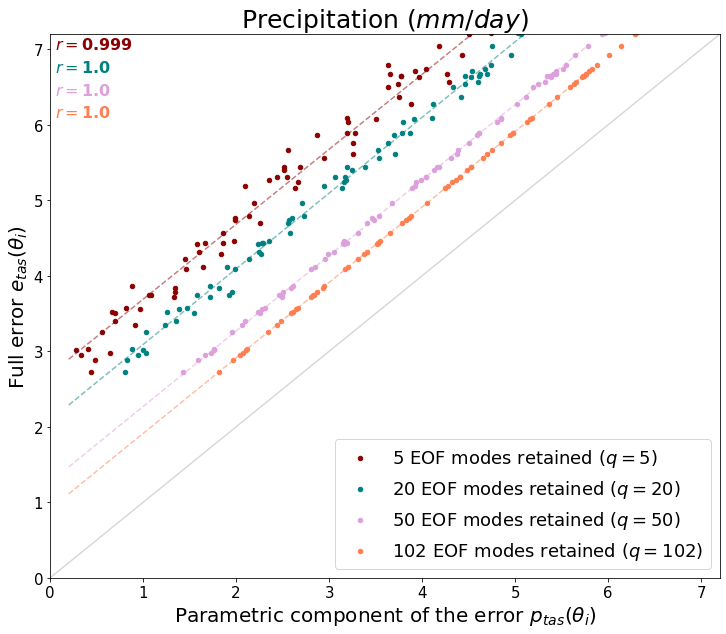

In [106]:
fig, ax = plt.subplots(figsize=(12,10))

## -- Regression line for different q
q=5
ax.plot(np.arange(0.2,5.8,0.02), corr[str(q)+' modes'][0], 
        linestyle='--', alpha=0.5,  color='darkred', 
        label='_nolegend_', zorder =20)
q=20
ax.plot(np.arange(0.2,5.8,0.02), corr[str(q)+' modes'][0], 
        linestyle='--', alpha=0.5,  color='teal', 
        label='_nolegend_', zorder =20)
q=50
ax.plot(np.arange(0.2,5.8,0.02), corr[str(q)+' modes'][0], linestyle='--', alpha=0.5,  
        color='plum', 
        label='_nolegend_', zorder =20)
q=102
ax.plot(np.arange(0.2,5.8,0.02), corr[str(q)+' modes'][0], linestyle='--', alpha=0.5,  
        color='coral', 
        label='_nolegend_', zorder =20)

## -- Scatter plot for different q
q=5
df_fig_sort.plot(kind='scatter', x='pj 5 modes', y='ej', 
                           color='darkred', alpha=1, marker='o', ax = ax, zorder =1)
q=20
df_fig_sort.plot(kind='scatter', x='pj 20 modes', y='ej', 
                           color='teal', alpha=1, marker='o', ax = ax, zorder =1)
q=50
df_fig_sort.plot(kind='scatter', x='pj 50 modes', y='ej', 
                           color='plum', alpha=1, marker='o', ax = ax, zorder =1)
q=102
df_fig_sort.plot(kind='scatter', x='pj 102 modes', y='ej', 
                           color='coral', alpha=1, marker='o', ax = ax, zorder =1)



## -- Regression line for the diagonal (0,0)
ax.plot(np.arange(0.0,10.0,0.02), np.arange(0.0,10.0,0.02), 
        linestyle="-", alpha=0.3,  color='gray', 
        label='_nolegend_')

## -- Legend and settings
legend=['5 EOF modes retained ($q=5$)', 
        '20 EOF modes retained ($q=20$)', 
        '50 EOF modes retained ($q=50$)', 
        '102 EOF modes retained ($q=102$)']
#ax.text(x=1.6, y=0.7, s='Pearson correlation coefficients :', fontsize=16)
ax.text(x=0.05, y=7.0, s='$r = $'+str(corr['5 modes'][1]), fontsize=16, 
        color='darkred', fontweight='bold')
ax.text(x=0.05, y=6.7, s='$r = $'+str(corr['20 modes'][1]), fontsize=16, 
        color='teal', fontweight='bold')
ax.text(x=0.05, y=6.4, s='$r = $'+str(corr['50 modes'][1]), fontsize=16, 
        color='plum', fontweight='bold')
ax.text(x=0.05, y=6.1, s='$r = $'+str(corr['102 modes'][1]), fontsize=16, 
        color='coral', fontweight='bold')
ax.tick_params(axis='both', which='major', labelsize=15)
plt.legend(legend, fontsize=18, loc='lower right') #, bbox_to_anchor=(1.5, 1.02))
plt.title('Precipitation ($mm/day$)', fontsize = 25)
plt.xlabel('Parametric component of the error $p_{tas}(\\theta_i)$',fontsize=20)
plt.ylabel('Full error $e_{tas}(\\theta_i)$',fontsize=20)
plt.ylim(0,7.2)
plt.xlim(0,7.2)

# Enregistrer la figure ...........

plt.savefig("/data/home/globc/peatier/figures/Corr_decompo_example_"+variable+".png", 
        orientation='portrait', bbox_inches='tight', pad_inches=0.1)

# Display the figure 
plt.show()